# Lesson 2 : LangGraph Components

In [1]:
import os
from typing import TypedDict, Annotated
import operator
from dotenv import load_dotenv, find_dotenv

#from gigachat.models import Chat, Messages, MessagesRole, chat_completion
from langchain_gigachat.chat_models import GigaChat
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

_ = load_dotenv(find_dotenv())

api_key  = os.getenv('GIGACHAT_API_KEY')

model = GigaChat(credentials=api_key, verify_ssl_certs=False, temperature = 0)

In [2]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> Если вы не знакомы с аннотациями к набору текста на python, вы можете обратиться к [документам на python](https://docs.python.org/3/library/typing.html).

> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Примечание: в `take_action`, приведенном ниже, была добавлена некоторая логика, чтобы учесть случай, когда LLM возвращает несуществующее имя инструмента. Даже при вызове функции LLM все равно может иногда вызывать галлюцинации. Обратите внимание, что все, что делается, - это указание LLM повторить попытку! Преимущество агентурной организации.

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [4]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [5]:
prompt = """
Вы - толковый научный сотрудник. Используйте поисковую систему для поиска информации. \
Вам разрешено совершать несколько звонков (как одновременно, так и последовательно). \
Ищите информацию только тогда, когда вы уверены в том, что вам нужно. \
Если вам нужно найти какую-то информацию, прежде чем задать уточняющий вопрос, вы можете это сделать!
"""

abot = Agent(model, [tool], system=prompt)

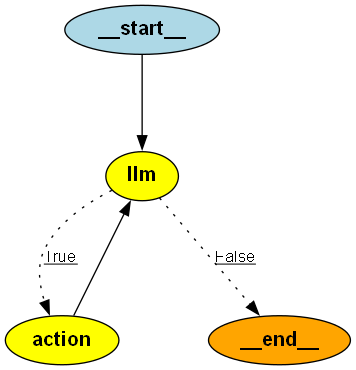

In [6]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [7]:
messages = [HumanMessage(content="Какая погода в СПБ?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'погода в СПБ'}, 'id': 'c733d259-abba-4725-a1ad-991d0b9c7a66', 'type': 'tool_call'}
Back to the model!


In [8]:
result

{'messages': [HumanMessage(content='Какая погода в СПБ?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': {'query': 'погода в СПБ'}}, 'functions_state_id': '5f3e037f-c30a-46bc-80c0-57eaed9ebe3d'}, response_metadata={'token_usage': {'prompt_tokens': 195, 'completion_tokens': 36, 'total_tokens': 231}, 'model_name': 'GigaChat:1.0.26.20', 'finish_reason': 'function_call'}, id='run-3a257e44-1f29-49be-ad3b-ff9057834652-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'погода в СПБ'}, 'id': 'c733d259-abba-4725-a1ad-991d0b9c7a66', 'type': 'tool_call'}]),
  ToolMessage(content="[{'url': 'https://www.meteoservice.ru/weather/today/sankt-peterburg', 'content': 'Санкт-Петербурге сегодня по часам\\nКарточки погоды на сегодня\\nХарактер погоды\\nТемпература\\nВетер\\nОсадки\\nХарактер погоды\\nТемпература\\nВетер\\nОсадки\\nПогода в Санкт-Петербурге по часам\\nСегодня в

In [9]:
result['messages'][-1].content

'Погода в Санкт-Петербурге на данный момент облачная и зябкая. Температура воздуха составляет около +2 градусов Цельсия. Ожидается небольшой дождь со снегом. Ветер слабый.'

In [13]:
messages = [HumanMessage(content="Какая сейчас погода в Москве и Санкт-Петербурге?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Moscow and St Petersburg'}, 'id': '026ec308-8d10-4dfa-9f06-c36eca02356c', 'type': 'tool_call'}
Back to the model!


In [14]:
result

{'messages': [HumanMessage(content='Какая сейчас погода в Москве и Санкт-Петербурге?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': {'query': 'current weather in Moscow and St Petersburg'}}, 'functions_state_id': 'a2c8a7f2-ddd2-4ef1-9f6c-3384befe531a'}, response_metadata={'token_usage': {'prompt_tokens': 199, 'completion_tokens': 38, 'total_tokens': 237}, 'model_name': 'GigaChat:1.0.26.20', 'finish_reason': 'function_call'}, id='run-724e6e31-0cbb-4fa6-bd9b-c55d4fdae671-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Moscow and St Petersburg'}, 'id': '026ec308-8d10-4dfa-9f06-c36eca02356c', 'type': 'tool_call'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Moscow\', \'region\': \'Moscow City\', \'country\': \'Russia\', \'lat\': 55.7522, \'lon\': 37.6156, \'tz_id\': \'E

In [15]:
result['messages'][-1].content

'Погода в Москве на данный момент ясная, температура около 0 градусов Цельсия. В Санкт-Петербурге также ясно, температура чуть ниже, около -1 градуса Цельсия.'

In [ ]:
query = "Какая команда стала чемпионом футбольной российской премьер-лиги в 2023?\
         Из какого она города? \
         Какие знаменитые игроки в ней играли?\
         Ответь на каждый вопрос." 
messages = [HumanMessage(content=query)]

model = GigaChat(credentials=api_key, 
                 verify_ssl_certs=False, 
                 temperature = 0,
                 model='GigaChat')

abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

In [26]:
result

{'messages': [HumanMessage(content='Какая команда стала чемпионом футбольной российской премьер-лиги в 2023?         Из какого она города?          Какие знаменитые игроки в ней играли?         Ответь на каждый вопрос.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Команда, ставшая чемпионом футбольной Российской Премьер-Лиги в сезоне 2023 года, называется "Зенит". Она представляет город Санкт-Петербург. В составе команды в этом сезоне играли такие известные футболисты как Малком, Клаудиньо и Вильмар Барриос.', additional_kwargs={'functions_state_id': 'b51283ac-36a5-4861-ac0a-933355653cdf'}, response_metadata={'token_usage': {'prompt_tokens': 230, 'completion_tokens': 70, 'total_tokens': 300}, 'model_name': 'GigaChat:1.0.26.20', 'finish_reason': 'stop'}, id='run-34ba8580-f553-4963-a1a5-f626e5b29234-0')]}

In [27]:
print(result['messages'][-1].content)

Команда, ставшая чемпионом футбольной Российской Премьер-Лиги в сезоне 2023 года, называется "Зенит". Она представляет город Санкт-Петербург. В составе команды в этом сезоне играли такие известные футболисты как Малком, Клаудиньо и Вильмар Барриос.


In [22]:
query = "Какая команда стала чемпионом футбольной российской премьер-лиги в 2023?\
         Из какого она города? \
         Какие знаменитые игроки в ней играли?\
         Ответь на каждый вопрос." 
messages = [HumanMessage(content=query)]

model = GigaChat(credentials=api_key, 
                 verify_ssl_certs=False, 
                 temperature = 0,
                 model='GigaChat-Max')

abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Чемпион футбольной российской премьер-лиги 2023'}, 'id': '44677c4e-7be8-492d-98d8-b31760a7c4ef', 'type': 'tool_call'}
Back to the model!


In [23]:
result

{'messages': [HumanMessage(content='Какая команда стала чемпионом футбольной российской премьер-лиги в 2023?         Из какого она города?          Какие знаменитые игроки в ней играли?         Ответь на каждый вопрос.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': {'query': 'Чемпион футбольной российской премьер-лиги 2023'}}, 'functions_state_id': 'c813b674-77e9-4177-8058-8c2e8a81d35c'}, response_metadata={'token_usage': {'prompt_tokens': 200, 'completion_tokens': 37, 'total_tokens': 237}, 'model_name': 'GigaChat-Max:1.0.26.20', 'finish_reason': 'function_call'}, id='run-4658dedf-801f-4ebe-9bf4-5faa003bbfa9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Чемпион футбольной российской премьер-лиги 2023'}, 'id': '44677c4e-7be8-492d-98d8-b31760a7c4ef', 'type': 'tool_call'}]),
  ToolMessage(content="[{'url': 'https://www.championat.com/football/news-556

In [17]:
print(result['messages'][-1].content)

В 2024 году чемпионами Российской Премьер-Лиги стали футболисты московского "Локомотива". Этот клуб является одним из самых титулованных в России, он был основан в 1923 году. Среди известных игроков, выступавших за "Локомотив", можно выделить Игоря Чугайнова, Дмитрия Лоськова и Дмитрия Сычева.


Вот честно, ситуация неприятная.
Версия Max воспользовалась инструментом Tavily, в отличии от Lite версии, которая ориентировалась на свои знания. Но даже так, Lite версия дала правильный ответ, а вот Max версия - нет. Вопрос, что виновато? Модель или Tavily, давший не самые релевантные статьи?